In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vgg16, vgg16_bn
from torch.utils.data import Dataset
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import sys
import os
from skimage import io

custom_style = {'axes.labelcolor': 'white'}
sns.set_style("dark", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18
%matplotlib inline

In [2]:
data_dir = '../data/'
batch_size = 100

In [3]:
mnist_LABEL_NAMES = (
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck')

## Cifar10の画像のcsvを作る

In [4]:
import glob
import os
import pandas as pd

In [5]:
train_img = glob.glob('../data/cifar10_pictures/train/*')
test_img = glob.glob('../data/cifar10_pictures/test/*')

In [6]:
def find_all_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if 'png' in file:
                yield os.path.join(root, file)

In [7]:
train_img = list(find_all_files('../data/mnist/train/'))
test_img = list(find_all_files('../data/mnist/test/'))

In [8]:
train_label = [os.path.basename(f).split('_')[0] for f in train_img]
test_label = [os.path.basename(f).split('_')[0] for f in test_img]

In [9]:
df_train = pd.DataFrame()
df_train['img'] = [os.path.join(i.split('/')[-2],i.split('/')[-1]) for i in train_img]
df_train['label'] = train_label
# df_train['label_index'] = df_train['label'].map(lambda x: CIFAR10_LABEL_NAMES.index(x))
df_test = pd.DataFrame()
df_test['img'] = [os.path.join(i.split('/')[-2],i.split('/')[-1]) for i in test_img]
df_test['label'] = test_label
# df_test['label_index'] = df_test['label'].map(lambda x: CIFAR10_LABEL_NAMES.index(x))

In [10]:
train_num = 10
test_num = 100
seed = 1
df_train_pick = pd.DataFrame()
df_test_pick = pd.DataFrame()

df_train_pick = df_train_pick.append(df_train.sample(n=100, random_state=seed))
df_test_pick = df_test_pick.append(df_test.sample(n=1000, random_state=seed))

# for label in range(10):
#     df_train_pick = df_train_pick.append(df_train[df_train.label == str(label)].sample(n=train_num, random_state=seed))
#     df_test_pick = df_test_pick.append(df_test[df_test.label == str(label)].sample(n=test_num, random_state=seed))
        

In [11]:
df_train_unlabel = df_train.drop(df_train_pick.index)

In [12]:
df_train_pick = df_train_pick.sample(frac=1).reset_index(drop=True)
df_test_pick = df_test_pick.sample(frac=1).reset_index(drop=True)
df_train_unlabel = df_train_unlabel.sample(frac=1).reset_index(drop=True)

In [26]:
df_train_label = df_train_pick

In [27]:
df_train_pick.to_csv('../data/mnist//train_small.csv', index=None)
df_test_pick.to_csv('../data/mnist/test_small.csv', index=None)
df_train.to_csv('../data/mnist/train_big.csv', index=None)
df_test.to_csv('../data/mnist/test_big.csv', index=None)
df_train_label.to_csv('../data/mnist/train_label.csv', index=None)
df_train_unlabel.to_csv('../data/mnist/train_unlabel.csv', index=None)

## 専用のデータ・セット作成

In [15]:
class MNISTDataSet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):

        self.image_dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.image_dataframe.loc[idx, 'img'])
#         image = io.imread(img_name)
        image = Image.open(img_name)
        label = self.image_dataframe.loc[idx, 'label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [16]:
csv_file = '../data/mnist/train_label.csv'
root_train = '../data/mnist/train/'
root_test = '../data/mnist/test/'

In [17]:
df = pd.read_csv(csv_file)
im_name = os.path.join(root_train, df.loc[0, 'img'])
im = io.imread(im_name)

In [18]:
## データの水増しと正規化
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

dataset = MNISTDataSet(csv_file, root_train, transform)
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [34]:
len(dataset)

100

In [32]:
idx = 3
loader = iter(trainloader)
d = next(loader)

In [33]:
def unnorm(tensor):
    mean=np.array([0.5, 0.5, 0.5])
    std=np.array([0.5, 0.5, 0.5])
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

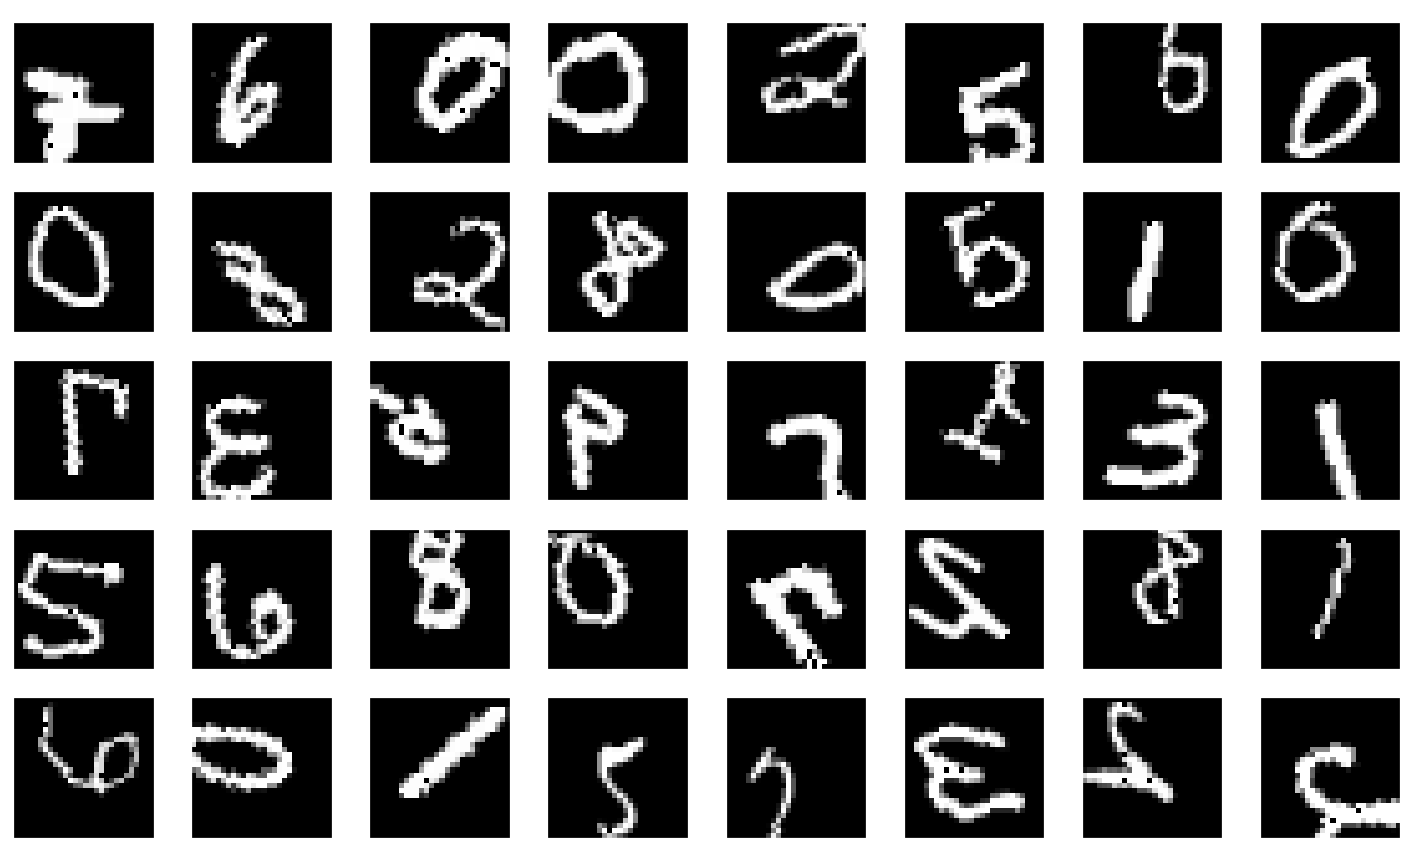

In [19]:
fig, axs = plt.subplots(5, 8, figsize=(25, 15))
for i in range(5):
    for j in range(8):
        idx = 8*i + j
        img = d[0][idx]
        label = d[1][idx]
        img = unnorm(img)
        img_numpy = img.numpy().transpose(1,2,0)
        plt.gray()
        axs[i,j].imshow(img_numpy[:,:,0])
        axs[i,j].set_title('{}'.format(label))
        axs[i,j].set_xticklabels([]) 
        axs[i,j].set_yticklabels([]) 
                